### Instacart Data Analysis

This notebook is created as part of daily playbook practice. The note book contains data ingestion, to data analysis of the instacart dataset sources from Kaggle. 



In [1]:
%%sh 
cd /kaggle/input/d/psparks/instacart-market-basket-analysis
ls

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv


In [2]:
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

In [3]:
file_path="/kaggle/input/d/psparks/instacart-market-basket-analysis/"

In [4]:
aisles=pd.read_csv(file_path+"aisles.csv")
aisles.describe(include='all').head(2)

,aisle_id,aisle
count,134.0,134
unique,NaN,134


In [5]:
dept=pd.read_csv(file_path+"departments.csv")
dept.describe(include='all').head(2)

,department_id,department
count,21.0,21
unique,NaN,21


In [6]:
order_train = pd.read_csv(file_path+"order_products__train.csv")
order_train.describe(include='all').head(2)

,order_id,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,2.555624e+04,8.758044e+00,5.985944e-01


In [7]:
order_prior=pd.read_csv(file_path+"order_products__prior.csv")

In [8]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
orders = pd.read_csv(file_path+"orders.csv")

In [10]:
orders[["order_id","order_number"]].sort_values(by="order_id",ascending=True)

,order_id,order_number
1868044,1,4
3355525,2,3
3417191,3,16
2958007,4,36
2593373,5,42
...,...,...
1809968,3421079,6
877324,3421080,2
1949724,3421081,1
2903252,3421082,23


Seems like the order_train and order_prior data have mutually exclusive info when it 
comes to the order_id details. 

In [11]:
products = pd.read_csv(file_path+"products.csv")
products.describe(include='all').head(2)

,product_id,product_name,aisle_id,department_id
count,49688.0,49688,49688.0,49688.0
unique,NaN,49688,NaN,NaN


Datasets Information:

The datamodel is like the hub n spoke model. Multiple fact tables
are taking care of different facts.These facts can be joined to 
create one_table

Fact tables and their keys:
1) products : product_id, aisle_id, department_id
2) orders : order_id, user_id
3) order_prior : order_id, product_id

In [12]:
import seaborn as sns

In [13]:
sns.set(rc={'figure.figsize':(15,8)})

In [14]:
#start with the counts of individual tables
tableCounts = pd.DataFrame({'Aisles':[134],
'Dept': [21],
'ProductsPerDpt':[49688/21],
'ProductsPerAisle':[49688/134]})
tableCounts

,Aisles,Dept,ProductsPerDpt,ProductsPerAisle
0,134,21,2366.095238,370.80597


In [15]:
tableCounts = tableCounts.transpose().reset_index()
tableCounts.columns = ['feature','count']

<AxesSubplot:xlabel='feature', ylabel='count'>

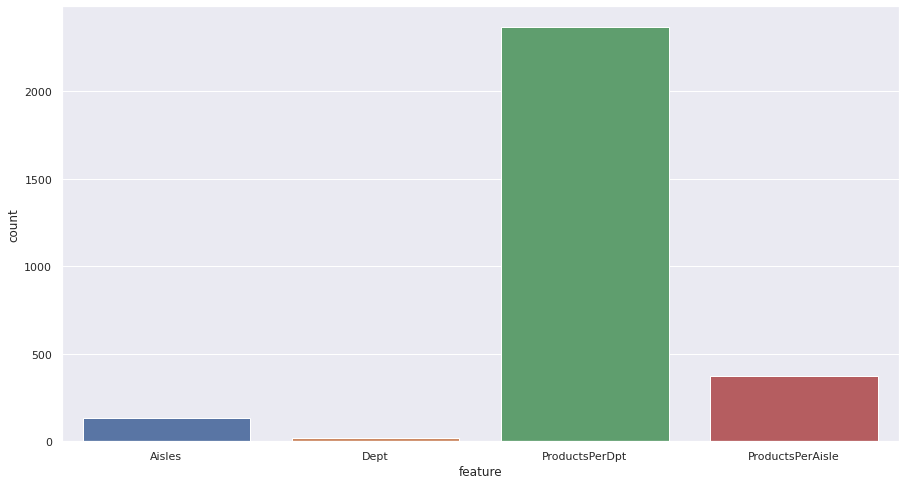

In [16]:
#This plot is based on manual calculations
sns.barplot(data=tableCounts,x='feature',y='count')

Products or the Orders fact tables can be targeted for the data 
analysis. 

In [17]:
products_aisles = products.groupby('aisle_id').count()

In [18]:
products_aisles.sort_values(by='product_name',
                            ascending=False,inplace=True)
crowded_aisles = products_aisles[products_aisles.product_id > 800]

In [19]:
crowded_aisles = pd.pivot_table(data=crowded_aisles,values=['product_id'],columns=['aisle_id'])

In [20]:
crowded_aisles=crowded_aisles.transpose().reset_index()

In [21]:
crowded_aisles

,aisle_id,product_id
0,3,832
1,21,891
2,22,816
3,37,1091
4,38,880
5,45,1246
6,47,1038
7,61,874
8,94,894
9,100,1258


<AxesSubplot:xlabel='aisle_id', ylabel='product_id'>

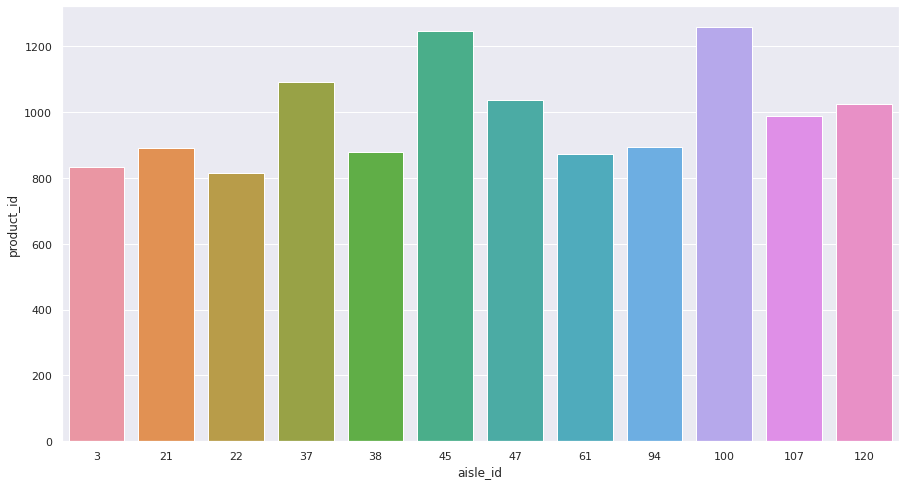

In [22]:
sns.barplot(data=crowded_aisles,x='aisle_id',y='product_id')

In [23]:
free_aisles = products_aisles[products_aisles.product_id < 200]
free_aisles.sort_values(by='product_id',ascending=False,inplace=True)
free_aisles = pd.pivot_table(data=free_aisles,values=['product_id'],columns=['aisle_id'])

In [24]:
free_aisles = free_aisles.transpose().reset_index()
free_aisles.head(5)

,aisle_id,product_id
0,1,146
1,7,100
2,12,123
3,14,159
4,15,80


<AxesSubplot:xlabel='aisle_id', ylabel='product_id'>

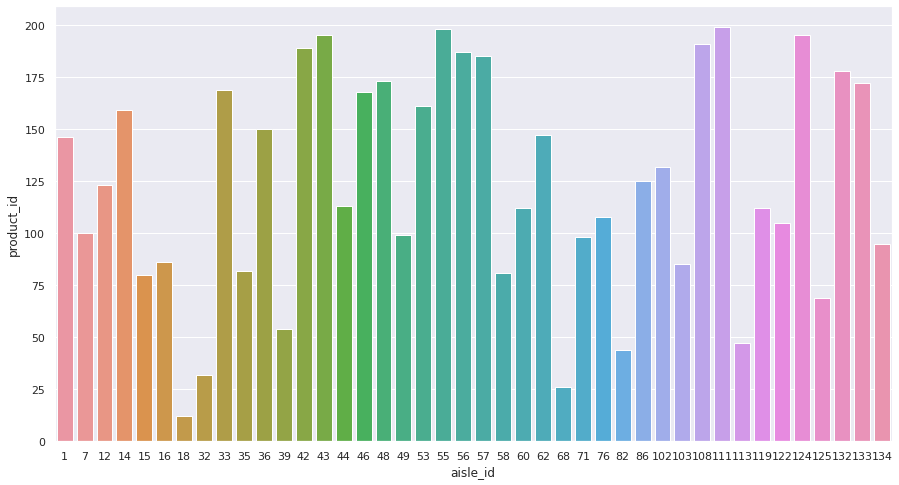

In [25]:
sns.barplot(data=free_aisles,x='aisle_id',y='product_id')

In [26]:
department_counts = products.groupby('department_id').count()
department_counts.sort_values(by='product_id',
                              ascending=False, inplace=True)

<AxesSubplot:xlabel='department_id', ylabel='product_id'>

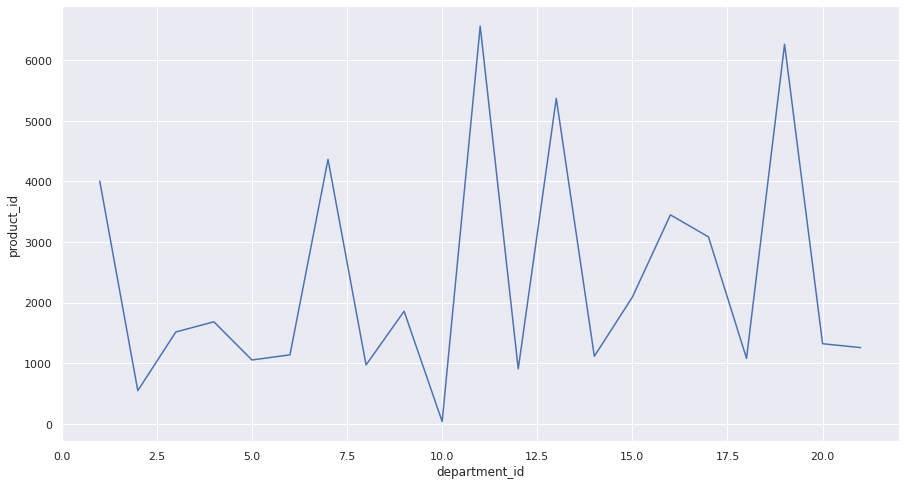

In [27]:
sns.lineplot(data=department_counts,x='department_id',
             y='product_id')

Shifting our focus to the orders dataset to understand 

- Which product is ordered the most

- which aisle has most orders

There are 3.4 million orders in the datasets. If you groupby the user_id, and count there are 206k+ users. 

Initially I thought that one of the user will have maximum orders. After analysing the data, found something different.

In [28]:
#There are 3.4 Million orders

order_user = orders[['order_id','user_id']].groupby('user_id').count()
order_user.sort_values(by='order_id',ascending=False,inplace=True)
order_user.reset_index(inplace=True)
order_user.head(5)

,user_id,order_id
0,152340,100
1,185641,100
2,185524,100
3,81678,100
4,70922,100


In [29]:
# Okay... There are 206k+ customers
order_user.columns = ['user_id','order_count']
order_user.describe()

,user_id,order_count
count,206209.000000,206209.000000
mean,103105.000000,16.590367
std,59527.555167,16.654774
min,1.000000,4.000000
25%,51553.000000,6.000000
50%,103105.000000,10.000000
75%,154657.000000,20.000000
max,206209.000000,100.000000


Minimum and maximum number of orders done by a users in the dataset 
is varying between 4 and 100. 

Question is, why there are more customers who have made 100 orders?

<AxesSubplot:xlabel='order_count', ylabel='Count'>

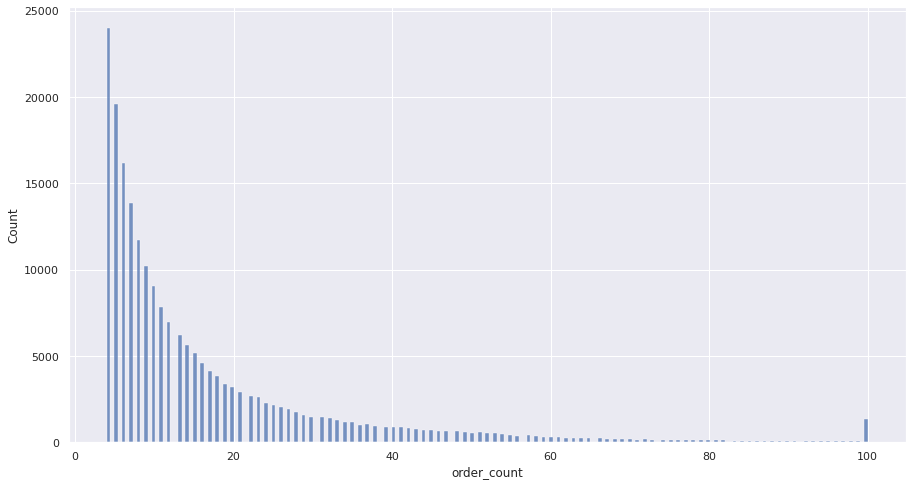

In [30]:
# Which user is ordering the most resulted in more than one user...

sns.histplot(data=order_user,x='order_count',stat='count')

### Lets start joining the orders and order_prior table, so the product_id can be identified

In [31]:
order_withPrior = orders.join(order_prior.set_index('order_id'),on='order_id',
            rsuffix="_op",lsuffix='_or',how='right')

In [32]:
order_withPrior.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
3355525,2,202279,prior,3,5,9,8.0,33120,1,1
3355525,2,202279,prior,3,5,9,8.0,28985,2,1
3355525,2,202279,prior,3,5,9,8.0,9327,3,0
3355525,2,202279,prior,3,5,9,8.0,45918,4,1
3355525,2,202279,prior,3,5,9,8.0,30035,5,0


In [33]:
product_order_count = order_withPrior.groupby("product_id").count()

In [34]:
product_order_count = product_order_count.reset_index()[['product_id','order_id']]

In [35]:
productsNcounts = products.join(product_order_count.set_index('product_id'),how='inner',on='product_id')

In [36]:
productsNcounts.columns = ['product_id', 'product_name', 'aisle_id', 'department_id', 'order_count']

In [37]:
productsNcounts.sort_values(by='order_count',ascending=False).head()

,product_id,product_name,aisle_id,department_id,order_count
24851,24852,Banana,24,4,472565
13175,13176,Bag of Organic Bananas,24,4,379450
21136,21137,Organic Strawberries,24,4,264683
21902,21903,Organic Baby Spinach,123,4,241921
47208,47209,Organic Hass Avocado,24,4,213584


In [38]:
aisle_order_counts = productsNcounts.groupby('aisle_id').sum('order_count').\
        reset_index()[["aisle_id","order_count"]]
aisle_order_counts.sort_values("order_count",ascending=False,inplace=True)

In [39]:
aisle_order_counts

,aisle_id,order_count
23,24,3642188
82,83,3418021
122,123,1765313
119,120,1452343
20,21,979763
...,...,...
43,44,8974
101,102,8581
81,82,8160
131,132,6168


<AxesSubplot:xlabel='aisle_id', ylabel='order_count'>

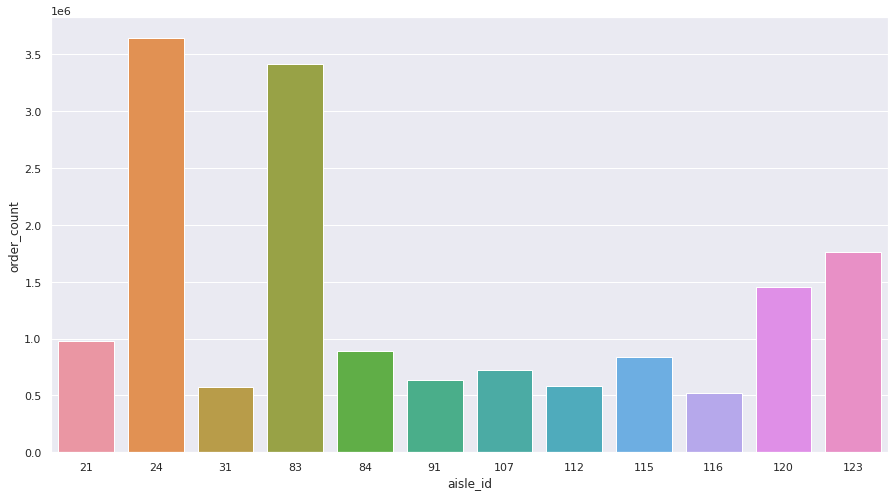

In [40]:
sns.barplot(data=aisle_order_counts[aisle_order_counts.order_count > 500000],
            x='aisle_id',y='order_count')